#Import the neccesssary supporting files

In [ ]:
!wget https://til-ai.sbs/horse.png
!wget https://til-ai.sbs/tiger.png

# Single Shot Detecor (SSD)

In [ ]:
!pip install torch torchvision
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

ssd_model.to('cuda')
ssd_model.eval()

def prepare_input(filepath):
    image = Image.open(filepath).convert('RGB')
    image = np.array(image.resize((300, 300), resample=Image.BILINEAR))
    image = image.astype(np.float32) / 255.0
    image = (image - 0.5) / 0.5
    return torch.tensor(image.transpose((2, 0, 1))).unsqueeze(0)

def detect_objects(image_path):
    input_image = prepare_input(image_path).to('cuda')
    
    with torch.no_grad():
        detections_batch = ssd_model(input_image)
    
    results_per_input = utils.decode_results(detections_batch)
    best_results = utils.pick_best(results_per_input[0], 0.40)
    
    return best_results

def display_detection_results(image_path, best_results):
    classes_to_labels = utils.get_coco_object_dictionary()
    input_image = prepare_input(image_path)
    
    fig, ax = plt.subplots(1)
    image = input_image.cpu().numpy().squeeze() / 2 + 0.5
    ax.imshow(image.transpose(1, 2, 0))
    
    bboxes, classes, confidences = best_results
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


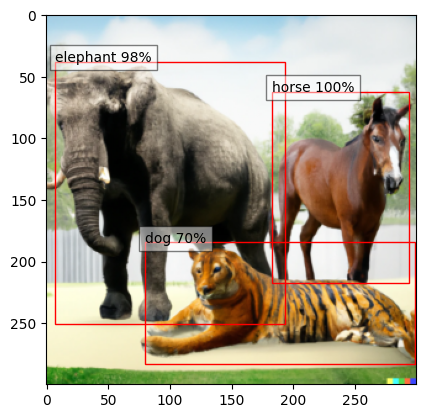

In [ ]:
# Upload a local image for testing
filepath = '/content/horse.png'

# Detect objects in the image
best_results = detect_objects(filepath)

# Display the detection results
display_detection_results(filepath, best_results)

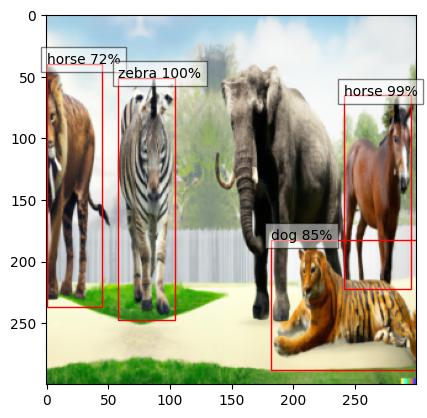

In [ ]:
# Upload a local image for testing
filepath = '/content/tiger.png'

# Detect objects in the image
best_results = detect_objects(filepath)

# Display the detection results
display_detection_results(filepath, best_results)

# Faster R-CNN

In [ ]:
# Import necessary libraries
import torch
import torchvision
import numpy as np
import cv2
from PIL import Image
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import ToTensor

def create_faster_rcnn_model():
    # Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    return model

def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return ToTensor()(img).unsqueeze(0)

# Create the Faster R-CNN model
model = create_faster_rcnn_model()

In [ ]:
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt

def load_class_names(file_path):
    with open(file_path, "r") as f:
        class_names = [line.strip() for line in f.readlines()]
    return class_names

class_names = load_class_names("coco-labels-paper.txt")

def test_faster_rcnn_model(model, image_path, threshold=0.5):
    # Load and preprocess the image
    img_tensor = load_image(image_path)
    
    # Make sure the model is in evaluation mode
    model.eval()

    # Get predictions from the model
    with torch.no_grad():
        predictions = model(img_tensor)
    
    # Filter predictions based on the confidence threshold
    filtered_predictions = []
    for i, score in enumerate(predictions[0]["scores"]):
        if score > threshold:
            filtered_predictions.append({
                "bbox": predictions[0]["boxes"][i].tolist(),
                "score": score.item(),
                "class": int(predictions[0]["labels"][i])
            })

    # Load image using OpenCV and convert to RGB format
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes and labels on the image
    for pred in filtered_predictions:
        x1, y1, x2, y2 = map(int, pred["bbox"])
        class_label = class_names[pred["class"]]
        confidence = round(pred["score"] * 100, 2)
        label_text = f"{class_label}: {confidence}%"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

    # Display the image with bounding boxes and labels
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    return filtered_predictions

--2023-04-15 11:17:20--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco-labels-paper.txt.5’

coco-labels-paper.t 100%[===================>]     702  --.-KB/s    in 0s      

2023-04-15 11:17:20 (51.5 MB/s) - ‘coco-labels-paper.txt.5’ saved [702/702]



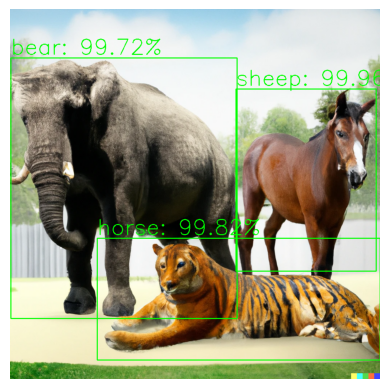

[{'bbox': [625.427490234375, 221.93865966796875, 1013.24560546875, 725.146484375], 'score': 0.999567449092865, 'class': 19}, {'bbox': [241.470458984375, 634.8031005859375, 1024.0, 971.2354736328125], 'score': 0.998202919960022, 'class': 18}, {'bbox': [2.550429582595825, 135.26963806152344, 628.7921142578125, 856.0756225585938], 'score': 0.9971994161605835, 'class': 22}]


In [ ]:
# Test the model with a local image
image_path = "/content/horse.png"
threshold = 0.5
predictions = test_faster_rcnn_model(model, image_path, threshold)

print(predictions)

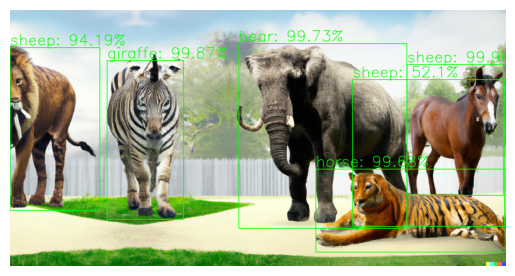

[{'bbox': [1588.99072265625, 218.8046417236328, 1973.5350341796875, 741.2957153320312], 'score': 0.9995951056480408, 'class': 19}, {'bbox': [388.3262023925781, 202.18179321289062, 694.3030395507812, 837.5499877929688], 'score': 0.998658299446106, 'class': 24}, {'bbox': [915.8824462890625, 134.01126098632812, 1587.0797119140625, 873.6613159179688], 'score': 0.9973046779632568, 'class': 22}, {'bbox': [1223.059326171875, 636.3900146484375, 1980.318359375, 968.6458740234375], 'score': 0.9967663288116455, 'class': 18}, {'bbox': [0.0, 150.30995178222656, 359.7818298339844, 801.6820678710938], 'score': 0.941928505897522, 'class': 19}, {'bbox': [1370.4658203125, 278.5347595214844, 1978.0867919921875, 865.5494384765625], 'score': 0.5210299491882324, 'class': 19}]


In [ ]:
# Test the model with a local image
image_path = "/content/tiger.png"
threshold = 0.5
predictions = test_faster_rcnn_model(model, image_path, threshold)

print(predictions)